# A Notebook for Data Plotting

## Imports

In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

In [2]:
import seaborn as sns
import colorcet as cc
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black"})
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": "--"})
colors = sns.color_palette(cc.CET_CBTL4)


In [3]:
# nice plot templates
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

--2023-05-16 15:52:23--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle.7’

rose-pine-dawn.mpls 100%[===================>]  39,95K  --.-KB/s    in 0,02s   

2023-05-16 15:52:23 (1,74 MB/s) - ‘/tmp/rose-pine-dawn.mplstyle.7’ saved [40905/40905]



## Data Imports

In [4]:
stats_signif = 13
n_base_scenarios = 10
n_test_scenarios = 8
n_rule_scenarios = 32

In [5]:
baseline_dfs = [[] for _ in range(n_base_scenarios)]
for scenario in range(n_base_scenarios):
        for k in range(stats_signif):
            path = f"../results/base/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                baseline_df = pd.read_csv(whole)
                baseline_dfs[scenario].append(baseline_df)


In [6]:
test_dfs = [[] for _ in range(n_test_scenarios)]
for scenario in range(n_test_scenarios):
        for k in range(13):
            path = f"../results/test/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                test_df = pd.read_csv(whole)
                test_dfs[scenario].append(test_df)

In [7]:
rules_dfs = [[] for _ in range(n_rule_scenarios)]
for scenario in range(n_rule_scenarios):
        for k in range(13):
            path = f"../results/rule_trials/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                rules_df = pd.read_csv(whole)
                rules_dfs[scenario].append(rules_df)

# Dataframes so far:
1. baseline_dfs
2. test_dfs
3. rules_dfs

In [8]:
settings_path = "../results/settings.csv"
settings_names_path = "../results/settings_names.csv"
settings_lambda_path = "../results/settings_lambda.csv"
settings = pd.read_csv(settings_path)
settings_names = pd.read_csv(settings_names_path)
settings_lambda = pd.read_csv(settings_lambda_path)


In [9]:
all_rules = rules_dfs[0][0].columns.tolist()

# Basic Stats

## Correlation of Trials

In [10]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [11]:
def spearman_trials(df_list: list) -> None:
    # Create an empty matrix to store the kappa values
    heatmap_data = np.zeros((13, 13))
    p_values = np.zeros((13, 13))
    num_settings = len(df_list)
    num_trials = len(df_list[0])

    for trial1 in range(num_trials):
        for trial2 in range(num_trials):
            # Accumulate the correlation values across all settings
            total_correlation = 0
            total_p_value = 0
            valid_settings = 0

            for i in range(num_settings):
                # Get the data for the current trials from the corresponding dataframes
                data1 = df_list[i][trial1].values.flatten()
                data2 = df_list[i][trial2].values.flatten()

                # Find indices where both data vectors are not NaN
                valid_indices = np.logical_and(~np.isnan(data1), ~np.isnan(data2))
                valid_data1 = data1[valid_indices]
                valid_data2 = data2[valid_indices]

                # Compute the correlation coefficient and p-value
                correlation, p_value = spearmanr(valid_data1, valid_data2)
                
                # Accumulate the correlation value for the current trial pair
                if not np.isnan(correlation):
                    total_correlation += correlation
                    total_p_value += p_value
                    valid_settings += 1
            
            # Average the correlation values over the valid settings
            if valid_settings > 0:
                heatmap_data[trial1, trial2] = total_correlation / valid_settings
                p_values[trial1, trial2] = total_p_value / valid_settings
    
    normalized_data = heatmap_data
    # Rescale the correlation values between -1 and 1
    max_abs_val = np.max(np.abs(heatmap_data))
    if max_abs_val != 0:
        normalized_data = heatmap_data / max_abs_val
    else:
        normalized_data = heatmap_data
    
    # Plot the heatmap
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12, 9))
        sns.heatmap(normalized_data, cmap='YlOrRd', annot=False, fmt=".2f", linewidths=0.5, cbar=True)
        plt.xlabel('Trial')
        plt.ylabel('Trial')
        plt.title(f"Averaged of Spearman Correlation for all {num_settings} Settings")
        plt.show()

    # Print the p-values
    print("P-values:")
    for i in range(13):
        for j in range(13):
            if not p_values[i, j] == 0.0:
                print(f"Trial {i+1} vs Trial {j+1}: {p_values[i, j]}")

# Experiment Settings

# Pro-Social Behavior

Collected Data:

- A. Obtained Reward per Timestep per Agent
- B. Number of Dissceted Fields per Timesteo (Quantative Measure of Environment Destruction)

## A. Obtained Reward at Timestep for 
1. Baseline
2. Rule Combinations (all 4 agents)
3. Role Combination (all 5 rules)

In [12]:
def plot_rewards_and_dissected(df_list: list):
    # data is stored in a list of 32 lists called `data_list`
    averages = []
    num_settings = len(df_list)
    num_trials = len(df_list[0])

    for i in range(num_settings):
        mean_rewards = pd.DataFrame()
        mean_dessicated = pd.Series(0, index=range(len(df_list[0][0])))

        for j in range(num_trials):
            df = df_list[i][j] # Get the j-th dataframe for the i-th setting
            rewards = df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
            mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards

            dessicated = df.iloc[:, 9]
            mean_dessicated = mean_dessicated.add(dessicated)

        mean_rewards = mean_rewards.divide(num_trials) # Divide the sum by the number of dataframes (8) to get the mean
        averages.append(mean_rewards)

        """ 
        COMMENT OUT THE FOLLOWING TO GET PLOTS PER SETTING
        fig, ax = plt.subplots(figsize=(8,6))
        mean_rewards_cum = mean_rewards.cumsum()
        cur_rules = settings_names.iloc[i, 3].split(', ')
        rule_out = '\n'.join([str(elem) for elem in cur_rules])
        info_text = f"Active rules: {len(cur_rules)}\n {rule_out}"
        ax.text(0.5, -0.1, info_text, ha='center', transform=fig.transFigure, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))
        ax.plot(mean_rewards_cum) # Plot the cumulative mean reward evolution for the current setting
        ax.set_title(f'Cumulative average reward evolution for setting {i+1}')
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Cumulative average reward")
        ax.legend(labels=mean_rewards.columns) # Add a legend with the column names
        plt.show()"""

    mean_dessicated = mean_dessicated / (num_settings * num_trials)
    average_rewards = pd.concat(averages).groupby(level=0).mean() # Concatenate all mean rewards and compute the average across all settings
    average_rewards_cum = average_rewards.cumsum() # Compute the cumulative average rewards

    # Plot the rewards
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        fig, ax1 = plt.subplots()
        # Plot each dimension with a different color
        for i, col in enumerate(average_rewards_cum.columns):
            plt.plot(average_rewards_cum[col], linewidth=2.5)

        labels = ['Reward Free Agent', 'Reward Cleaner', 'Reward Farmer', 'Reward Learner']
        ax1.set_ylabel('Mean Rewards')
        ax1.set_xlabel("Timestep")
        ax1.legend(loc='upper left', labels=labels)

        # Create a secondary y-axis
        ax2 = ax1.twinx()
        ax2.plot(mean_dessicated, label='Mean Dessicated Field Ratio')
        ax2.set_ylabel('Mean Dessicated Fields Ratio')
        ax2.legend(loc='lower right')

    plt.title(f'Cumulative Mean Reward and Mean Dessicated Ratio Across All {num_settings} Settings')
    plt.show()

## B. Ratio of Dissected Fields per Timestep with Reward Data for 
1. Baseline
2. Rule Combinations (all 4 agents)
3. Role Combination (all 5 rules)

## B.1 Baseline
Ratio of Dissected Fields per Timesteo with Reward Data

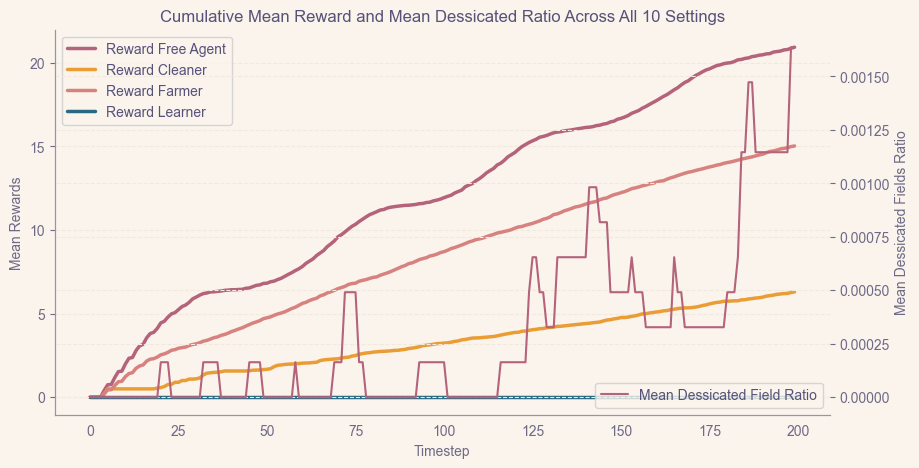

In [13]:
plot_rewards_and_dissected(baseline_dfs)

## B.2 Rule Combinations (all 4 agents)
Ratio of Dissected Fields per Timesteo with Reward Data

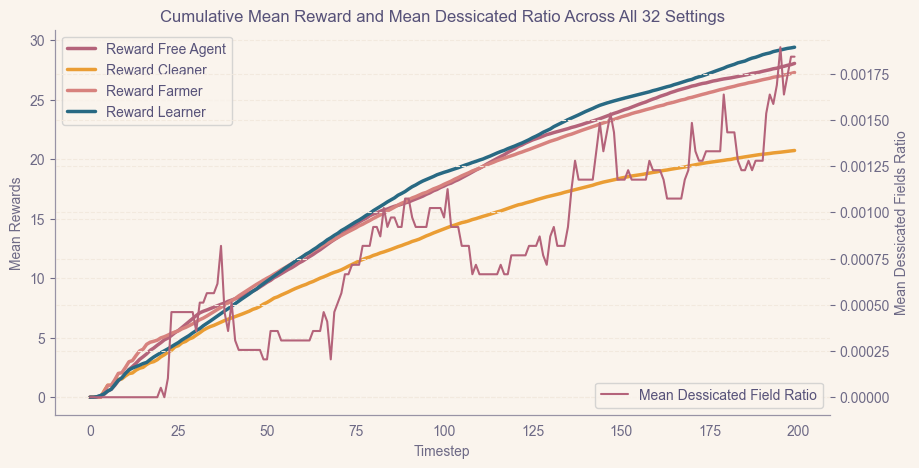

In [14]:
plot_rewards_and_dissected(rules_dfs)

## B.2 Role Combinations (all 5 rules)
Ratio of Dissected Fields per Timesteo with Reward Data

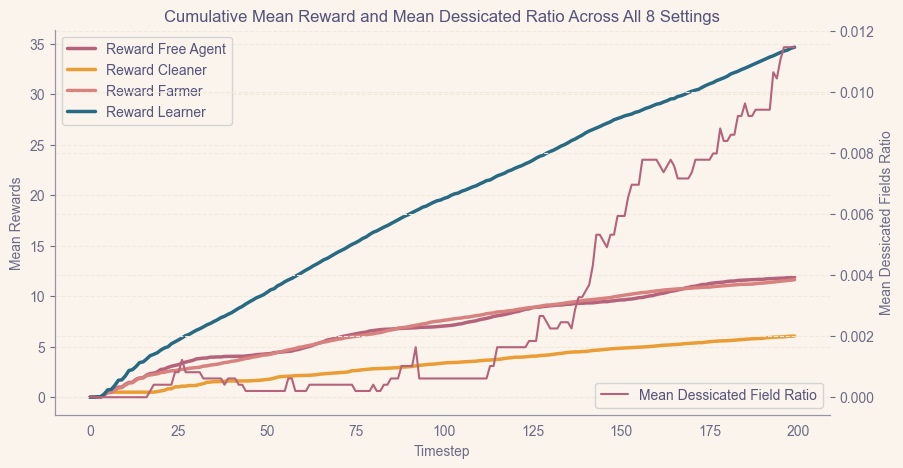

In [15]:
plot_rewards_and_dissected(test_dfs)

# Rule Learning

Collected Data:

- A. Ratio of Learned Rules per Timestep per Rule (Line Graph)
- B. Percentage of Learned Rules at Certain Timesteps (Boxplot)
- C. Timesteps where Certain Percentage of Rules has been learned (Boxplot)
- D. F1 Scores for all Combinations

## Data Declarations for Legends

### Getting the set of active rules in regard to rule or role combination

In [16]:
PROHIBITIONS = [
    "obs['NUM_APPLES_AROUND'] < 3 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION",
    "obs['CUR_CELL_HAS_APPLE'] and not obs['AGENT_HAS_STOLEN'] -> !MOVE_ACTION"
]
OBLIGATION_CLEANER = [
    "obs['SINCE_AGENT_LAST_CLEANED'] > 5 -> obs['SINCE_AGENT_LAST_CLEANED'] < 5"
]
OBLIGATION_FARMER = [
    "obs['SINCE_AGENT_LAST_PAYED'] > 15 -> obs['SINCE_AGENT_LAST_PAYED'] < 15"
]
OBLIGATION_FREE = [
    "obs['SINCE_AGENT_LAST_CLEANED'] > 30 -> obs['SINCE_AGENT_LAST_CLEANED'] < 30"
]
ACTIVE_RULES_PER_ROLE = [
    [],
    PROHIBITIONS + OBLIGATION_FREE,
    PROHIBITIONS + OBLIGATION_CLEANER,
    PROHIBITIONS,
    PROHIBITIONS + OBLIGATION_FREE + OBLIGATION_CLEANER,
    PROHIBITIONS + OBLIGATION_FREE,
    PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER,
    PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER + OBLIGATION_FREE
]

In [17]:
def get_active_rules(i: int, setting: str):
    """Returns a list of active rules in regard to the setting"""
    if setting == 'rules':
        return [rule for rule in settings_lambda.iloc[i, 3].strip("(").strip(")").split(", ")]
    elif setting == 'test':
        return ACTIVE_RULES_PER_ROLE[i]
    return

In [18]:
TEST_SETTING_NAME = [
    "Leaner",
    "Free + learner",
    "Cleaner + learner",
    "Farmer + learner",
    "Cleaner, free + learner",
    "Farmer, free + learner",
    "Cleaner, farmer + learner",
    "Cleaner, farmer, free + learner",
]

In [19]:
def get_setting_name(i: int, setting_str: str) -> str:
    """Returns a printable setting of roles for legend."""
    if setting_str == 'test':
        return TEST_SETTING_NAME[i]
    else:
        return settings_names.iloc[i, 3].split(", ")

In [20]:
RULE_NAME_DICT = {
    "obs['NUM_APPLES_AROUND'] < 3 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Prohibition: Don't collect apple if less than 3 apples around",
    "obs['CUR_CELL_HAS_APPLE'] and not obs['AGENT_HAS_STOLEN'] -> !MOVE_ACTION": "Prohibition: Don't collect apple if it's on forgein territory",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 5 -> obs['SINCE_AGENT_LAST_CLEANED'] < 5": "Obligation: If you're in the cleeaner role, clean every 5 steps",
    "obs['SINCE_AGENT_LAST_PAYED'] > 15 -> obs['SINCE_AGENT_LAST_PAYED'] < 15": "Obligation: If you're in the farmer role, pay your cleaner every 15 steps",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 30 -> obs['SINCE_AGENT_LAST_CLEANED'] < 30": "Obligation: If you're in the free role, clean every 30 steps"
}

In [21]:
def get_rule_name(rule: str) -> str:
    "Returns a printable rule in regard to the formal logic representation of it"
    return RULE_NAME_DICT[rule]

In [22]:
# List of all rules
ALL_RULES = PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER + OBLIGATION_FREE

## Declarations for Data of Interest (What Timesteps, What Percentages)

In [23]:
target_percentages = [0.2, 0.4, 0.6, 0.8, 0.99]
target_timesteps = [0, 20, 40, 50, 80, 120, 150, 180, 199]
num_timesteps = len(target_percentages)
num_trials = 13

## Functions for Extracting Data of Interest

In [24]:
def extract_tp_and_fn(df_list: list, num_setting: int, percentage: float, timestep: int, setting_str: str):
    """
    F1 Extractions:
    
        Returns true positives and false negatives for active and nonactive rules 
            for a certain percentage at a certain timestep setting for a specific setting.
    """

    tp_active = 0
    fn_active = 0
    tp_nonactive = 0
    fn_nonactive = 0

    # print(f'percentage: {percentage}, timestep: {timestep}')

    for trial in range(num_trials):

        df = df_list[num_setting][trial]
        active_rules = get_active_rules(num_setting, setting_str)
        if "" in active_rules:
            active_rules.remove("")

        """if trial == 0:
            print(f'setting: {num_setting}')
            print(f'active_rules: {active_rules}')
            print(f'percentage: {percentage}')"""
        
        for rule in active_rules:
            if df.loc[timestep, rule] >= percentage:
                tp_active += 1
            else:
                fn_active += 1
                
        for column in df.iloc[:, 10:].columns:
            if column not in active_rules:
                if df.loc[timestep, column] < percentage:
                    tp_nonactive += 1
                else:
                    fn_nonactive += 1

    #print(f'tp_active: {tp_active}, fn_active: {fn_active}, tp_nonactive: {tp_nonactive}, fn_nonactive: {fn_nonactive}')

    return tp_active, fn_active, tp_nonactive, fn_nonactive

In [25]:
def extract_timesteps(input_dfs: pd.DataFrame, num_settings: int, setting_str: str,
                      target_percentages: list, target_timesteps: list):
    """
    Returns list of dicts with each dict representing one run with extracted posteriors.

        Dict Values:
            Setting:                index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:                  index of trial (1 of 13)
            Dsicrete Timesteps:     list of timesteos x where x is ts where x > posterios y
            Discrete Percentages:   list of posterios for timesteps of interest
            All Values:             list of all posterios
            Num Active Rules:       number of active rules for this setting 
    """
    results = []
    for i in range(num_settings):
        for j in range(13):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            active_rules = get_active_rules(i, setting_str)
            if "" in active_rules:
                active_rules.remove("")
                
            # Extract only the active rules from the dataframe
            df_active = df[active_rules]
            num_active = len(active_rules)

            # Calculate the timesteps where the agent has learned 50%, 80%, and 100% of the rules
            learned = []
            for row in df_active.itertuples():
                if not len(df_active.columns) == 0:
                    learned.append(sum(row[1:]) / len(df_active.columns))
                else:
                    learned.append(sum(row[1:]))

            timesteps = []
            for target in target_percentages:
                flag = False
                for idx, percent in enumerate(learned):
                    if percent >= target:
                        timesteps.append(idx)
                        flag = True
                        break
                if flag == False:
                    timesteps.append(np.nan)

            # Calculate the percentage of rules learned at timesteps 10, 30, and 50
            percentages = []
            for target in target_timesteps:
                if not len(df_active.columns) == 0:
                    percentages.append(sum(df_active.iloc[target]) / len(df_active.columns))

                else:
                    percentages.append(sum(df_active.iloc[target]))

            # Store the results for this setting and trial
            results.append({'setting': i, 'trial': j, 'discrete_timesteps': timesteps, 
                            'discrete_percentages': percentages, 'all_values': learned,
                            'num_active_rules': num_active})

    return results

In [26]:
def extract_rules(input_dfs: pd.DataFrame, num_settings: int, rules: list, setting_str: str):
    """
    Returns list of dicts with each dict representing one run with extracted rule posteriors.

        Dict Values:
            Setting:            index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:              index of trial (1 of 13)
            Rule:               rule for this setting
            All Values:         list of all posteriors for this rule
    """
    results = []
    for i in range(num_settings):
        for j in range(13):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            active_rules = get_active_rules(i, setting_str)
            if "" in active_rules:
                active_rules.remove("")

            for idx, rule in enumerate(rules):
                # Extract only the active rules from the dataframe
                df_active = df[[rule]]

                learned = []
                for row in df_active.itertuples():
                    if not rule in active_rules:
                        learned.append(np.nan)
                    else:
                        if not len(df_active.columns) == 0:
                            learned.append(sum(row[1:]) / len(df_active.columns))
                        else:
                            learned.append(sum(row[1:]))

                # Step 4: Store the results for this setting and trial
                results.append({'setting': i, 'trial': j, 'rule': rule, 'rule_idx': idx, 'all_values': learned})

    return results

## Function for Calculating F1


In [27]:
def get_f1_score(tp, fn, tn, fp):
    """Returns F1 score for a number of tp, fn, tn, and fp"""
    if tp + fp == 0:
        tp = 1
    if tp + fn == 0:
        tp = 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score
    

In [28]:
def get_f1_across_settings_per_specific_ts_and_percentage(percentages: list, timesteps: list, df_list: list, settings_str: str):
    tp_total, fn_total, tn_total, fp_total = 0, 0, 0, 0
    num_settings = len(df_list)

    precision_vals = [[] for _ in range(len(percentages))]
    recall_vals = [[] for _ in range(len(percentages))]
    f1_vals = [[] for _ in range(len(percentages))]

    for p_idx, percentage in enumerate(percentages):
        for timestep in timesteps:
            for setting in range(num_settings):
                tp, fn, tn, fp = extract_tp_and_fn(df_list=df_list, 
                                                num_setting=setting, 
                                                percentage=percentage, 
                                                timestep=timestep, 
                                                setting_str=settings_str)

                tp_total += tp
                fn_total += fn
                tn_total += tn
                fp_total += fp
            
            num_combinations = num_trials * num_settings
            total_avg_tp = tp_total / num_combinations
            total_avg_fn = fn_total / num_combinations
            total_avg_tn = tn_total / num_combinations
            total_avg_fp = fp_total / num_combinations

            precision, recall, f1_score = get_f1_score(total_avg_tp, total_avg_fn, total_avg_tn, total_avg_fp)
            precision, recall, f1_score = round(precision, 3), round(recall, 3), round(f1_score, 3)

            precision_vals[p_idx].append(precision)
            recall_vals[p_idx].append(recall)
            f1_vals[p_idx].append(f1_score)

            # Print the results
            #print(f'Timestep {timestep}, percentage: {percentage}:\tPre: {precision}, Rec: {recall}, F1: {f1_score}')
            """print(f'Active rules TP: {total_avg_tp}')
            print(f'Non-active rules TP: {total_avg_fn}')
            print(f'Active rules FN: {total_avg_tn}')
            print(f'Non-active rules FN: {total_avg_fp}')"""

    return precision_vals, recall_vals, f1_vals

In [29]:
def get_f1_across_timesteps_and_percentages(percentages: list, timesteps: list, df_list: list, settings_str: str):
    """Calculates F1 score across all settings for a combination as well as per setting"""
    tp_total, fn_total, tn_total, fp_total = 0, 0, 0, 0
    num_settings = len(df_list)

    precision_vals = []
    recall_vals = []
    f1_vals = []

    for setting in range(num_settings):
        tp_intermediate, fn_intermediate, tn_intermediate, fp_intermediate = 0, 0, 0, 0
            
        for timestep in timesteps:
            for percentage in percentages:
                tp, fn, tn, fp = extract_tp_and_fn(df_list=df_list, 
                                                num_setting=setting, 
                                                percentage=percentage, 
                                                timestep=timestep, 
                                                setting_str=settings_str)

                tp_total += tp
                fn_total += fn
                tn_total += tn
                fp_total += fp

                tp_intermediate += tp
                fn_intermediate += fn
                tn_intermediate += tn
                fp_intermediate += fp
        
        num_combinations_intermediate = len(percentages) * len(timesteps) * num_trials
        intermediate_avg_tp = tp_intermediate / num_combinations_intermediate
        intermediate_avg_fn = fn_intermediate / num_combinations_intermediate
        intermediate_avg_tn = tn_intermediate / num_combinations_intermediate
        intermediate_avg_fp = fp_intermediate / num_combinations_intermediate

        precision, recall, f1_score = get_f1_score(intermediate_avg_tp, intermediate_avg_fn, intermediate_avg_tn, intermediate_avg_fp)
        precision, recall, f1_score = round(precision, 3), round(recall, 3), round(f1_score, 3)

        precision_vals.append(precision)
        recall_vals.append(recall)
        f1_vals.append(f1_score)

        # Print the results
        #print(f'Setting {setting+1}:\tPre: {precision}, Rec: {recall}, F1: {f1_score}')
        """print(f'Active rules TP: {intermediate_avg_tp}')
        print(f'Non-active rules TP: {intermediate_avg_fn}')
        print(f'Active rules FN: {intermediate_avg_tn}')
        print(f'Non-active rules FN: {intermediate_avg_fp}')"""
            
    num_combinations = len(percentages) * len(timesteps) * num_trials * num_settings
    total_avg_tp = tp_total / num_combinations
    total_avg_fn = fn_total / num_combinations
    total_avg_tn = tn_total / num_combinations
    total_avg_fp = fp_total / num_combinations

    total_precision, total_recall, total_f1_score = get_f1_score(total_avg_tp, total_avg_fn, total_avg_tn, total_avg_fp)
    total_precision, total_recall, total_f1_score = round(total_precision, 3), round(total_recall, 3), round(total_f1_score, 3)

    # Print the results
    print(f'Across all settings, timesteps, and percentages:\tPre: {total_precision}, Rec: {total_recall}, F1: {total_f1_score}')
    """print(f'Active rules TP: {total_avg_tp}')
    print(f'Non-active rules TP: {total_avg_fn}')
    print(f'Active rules FN: {total_avg_tn}')
    print(f'Non-active rules FN: {total_avg_fp}')"""

    return precision_vals, recall_vals, f1_vals

## Functions for Plotting

In [30]:
def plot_timestep_per_percentage(continuous_timesteps: list, 
                                 percentage: float) -> None:
    """Plots timestep at what a rule has reached a certain posterior, grouped by setting."""

    num_settings = len(continuous_timesteps)
    labels = [f'S{i+1}' for i in range(num_settings)]
    num_trials = len(continuous_timesteps[0])
    num_timesteps = len(continuous_timesteps[0][0])
    #colors = ['pink', 'lightblue', 'lightgreen', 'lightblue', 'pink']
    #rules = [RULE_NAME_DICT[key] for key in RULE_NAME_DICT.keys()]

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12, 4))
        boxplot_data = [[] for _ in range(num_settings)]
        for idx in range(num_settings):
            data = []
            for i in range(num_trials): # num trials
                for j in range(num_timesteps): # num timesteps
                    if continuous_timesteps[idx][i][j] >= percentage:
                        data.append(j)
                        break
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata
            
        plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
        """for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)"""
        
    # plt.legend(boxplot_data, rules, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Setting')
    plt.ylabel('Timesteps')
    plt.title(f'Number of Timesteps for Learning {int(percentage*100)}% of the Rules, by Setting')
    plt.show()

In [31]:
def plot_percentage_per_timestep(continuous_timesteps: list, 
                                 timestep: int) -> None:
    """Plots posterior that was reached at certain timestep, grouped by setting."""
    
    num_settings = len(continuous_timesteps)
    labels = [f'S{i+1}' for i in range(num_settings)]
    #colors = ['pink', 'lightblue', 'lightgreen', 'lightblue', 'pink']
    #rules = [RULE_NAME_DICT[key] for key in RULE_NAME_DICT.keys()]

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12, 4))
        boxplot_data = [[] for _ in range(num_settings)]
        for idx in range(num_settings):
            data = []
            for i in range(num_trials):
                data.append(continuous_timesteps[idx][i][timestep])
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata
            
        plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
        """for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)"""
        
    # plt.legend(boxplot_data, rules, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Setting')
    plt.ylabel('Percentage of Rules Learned')
    plt.title(f'Percentage of Learned Rules at Timestep {timestep}, by Setting')
    plt.show()


In [32]:
def plot_all_timesteps_per_percentage(all_values: list, 
                                      setting_str: str) -> None:
    """Plots continuous posteriors for each timestep, grouped by setting."""

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12,6))
        for setting in range(len(all_values)):
            setting_timesteps = np.array(all_values[setting])
            mean_timesteps = np.nanmean(setting_timesteps, axis=0)
            setting_name = get_setting_name(setting, setting_str)
            plt.errorbar([*range(len(mean_timesteps))], mean_timesteps, label=f'{setting_name}', linewidth=2.5)

    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('Percentage')
    plt.title('Percentage of Learned Rules per Timestep, by Setting')
    plt.show()

In [33]:
def plot_single_rule_learning(rules: list, 
                              all_values: list, 
                              setting_str: str) -> None:
    """Plots posterior of rule at certain timestep, grouped by rule."""

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(10,4))
        for idx, rule in enumerate(rules):
            rule_name = get_rule_name(rule)

            # Assuming your array is named 'data'
            averaged_data = np.nanmean(all_values[idx], axis=(0, 1))
            plt.plot(averaged_data, label=rule_name, linewidth=2.5)

    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Timesteps')
    plt.ylabel('Percentage')
    plt.title('Percentage of Learned Rules per Timestep, by Rule')
    plt.show()

In [34]:
def plot_rule_after_timestep_x(all_values: list, 
                               timestep: int) -> None:
    """Plots rule posterior after timestep x, grouped by rule"""

    labels = ['Pr1', 'Pr2', 'Ob1', 'Ob2', 'Ob3']
    colors = ['pink', 'lightblue', 'lightgreen', 'lightblue', 'pink']
    #rules = [RULE_NAME_DICT[key] for key in RULE_NAME_DICT.keys()]

    num_rules = len(all_values)
    num_settings = len(all_values[0])
    num_trials = len(all_values[0][0])

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(6, 4))
        boxplot_data = [[] for _ in range(num_rules)]
        for idx in range(len(ALL_RULES)):
            data = []
            for i in range(num_settings):
                for j in range(num_trials):
                    data.append(all_values[idx][i][j][timestep])
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata

        bplot = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
    # plt.legend(boxplot_data, rules, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Rule (Pr for Prohibition, Ob for Obligation)')
    plt.ylabel('Percentage of Rules Learned')
    plt.title(f'Percentage of Learned Rule at Timestep {timestep}')
    plt.show()


In [35]:
def plot_rule_timestep_at_percentage(all_values: list, 
                                    percentage: float) -> None:
    """Plots timestep at what a rule has reached a certain posterior, grouped by rule."""

    labels = ['Pr1', 'Pr2', 'Ob1', 'Ob2', 'Ob3']
    colors = ['pink', 'lightblue', 'lightgreen', 'lightblue', 'pink']
    #rules = [RULE_NAME_DICT[key] for key in RULE_NAME_DICT.keys()]

    num_rules = len(all_values)
    num_settings = len(all_values[0])
    num_trials = len(all_values[0][0])
    num_timesteps = len(all_values[0][0][0])

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(6, 4))
        boxplot_data = [[] for _ in range(num_rules)]
        for idx in range(num_rules):
            data = []
            for i in range(num_settings):
                for j in range(num_trials):
                    for h in range(num_timesteps):
                        if all_values[idx][i][j][h] >= percentage:
                            data.append(h)
                            break
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata
            
        bplot = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
    # plt.legend(boxplot_data, rules, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Rule (Pr for Prohibition, Ob for Obligation)')
    plt.ylabel('Timesteps')
    plt.title(f'Number of Timesteps for Learning {int(percentage*100)}% of the Rules, by Rule')
    plt.show()

In [36]:
def plot_pre_rec_f1(precision_values: list, recall_values: list, f1_values: list, timesteps: list):
    # Plotting precision, recall, and F1
    labels = [0.2, 0.4, 0.6, 0.8, 0.99]  # Posteriors
    num_f1_vals = len(f1_values)
    
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

        for i in range(num_f1_vals):
            axs[0].plot(timesteps, precision_values[i], label=f'Precision for {labels[i]}', marker='o')
            axs[1].plot(timesteps, recall_values[i], label=f'Recall for {labels[i]}', marker='s')
            axs[2].plot(timesteps, f1_values[i], label=f'F1 for {labels[i]}', marker='^')

        # Configure subplots
        axs[0].set_ylabel('Precision')
        axs[1].set_ylabel('Recall')
        axs[2].set_ylabel('F1')
        axs[2].set_xlabel('Time Steps')

        axs[0].legend(loc='upper right')
        axs[1].legend(loc='upper right')
        axs[2].legend(loc='upper right')

        plt.tight_layout()
        plt.show()

In [37]:
def plot_avg_pre_rec_f1(precision_values: list, recall_values: list, f1_values: list, timesteps: list):
    avg_precision = np.mean(precision_values, axis=0)
    avg_recall = np.mean(recall_values, axis=0)
    avg_f1 = np.mean(f1_values, axis=0)

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(8, 6))

        plt.plot(timesteps, avg_precision, label='Average Precision', marker='o')
        plt.plot(timesteps, avg_recall, label='Average Recall', marker='s')
        plt.plot(timesteps, avg_f1, label='Average F1', marker='^')

        plt.xlabel('Time Steps')
        plt.ylabel('Score')
        plt.title('Average Precision, Recall, and F1 Scores Across All Settings')
        plt.legend()
        plt.grid(True)
        plt.show()

In [38]:
def plot_avg_pre_rec_f1_per_setting(precision_values: list, recall_values: list, f1_values: list):
    num_settings = len(precision_values)
    
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(8, 6))
        settings = np.arange(num_settings)
        plt.scatter(settings, precision_values, label='Precision')
        plt.scatter(settings, recall_values, label='Recall')
        plt.scatter(settings, f1_values, label='F1')

        plt.xlabel('Setting Index')
        plt.ylabel('Score')
        plt.title('Average Precision, Recall, and F1 Scores by Setting')
        plt.legend()
        plt.grid(True)
        plt.show()

# A. Ratio of Learned Rules per Timestep per Setting

## A.1 Ratio of Learned Rules — Rule Combinations

In [39]:
num_settings = 32
setting_str = 'rules' # 'rules' or 'test'
df_list = rules_dfs

timestep_results = extract_timesteps(input_dfs=df_list, num_settings=num_settings, setting_str=setting_str,
                target_percentages=target_percentages, target_timesteps=target_timesteps)

single_rule_results = extract_rules(input_dfs=df_list, num_settings=num_settings, rules=ALL_RULES, setting_str=setting_str)

percentages_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
timesteps_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_timesteps = [[[] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_rules = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(ALL_RULES))]

for result in timestep_results:
    setting = result['setting']
    trial = result['trial']
    timesteps = result['discrete_timesteps']
    percentages = result['discrete_percentages']
    all_values = result['all_values']
    continuous_timesteps[setting][trial] = all_values
    
    for i in range(num_timesteps):
        timestep = i
        timesteps_all[setting][trial][timestep] = timesteps[i]
        percentages_all[setting][trial][timestep] = percentages[i]

continuous_timesteps_1 = continuous_timesteps[:5]
continuous_timesteps_2 = continuous_timesteps[5:15]
continuous_timesteps_3 = continuous_timesteps[15:26]
continuous_timesteps_4 = continuous_timesteps[26:]

for result in single_rule_results:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules[rule_idx][setting][trial] = all_values


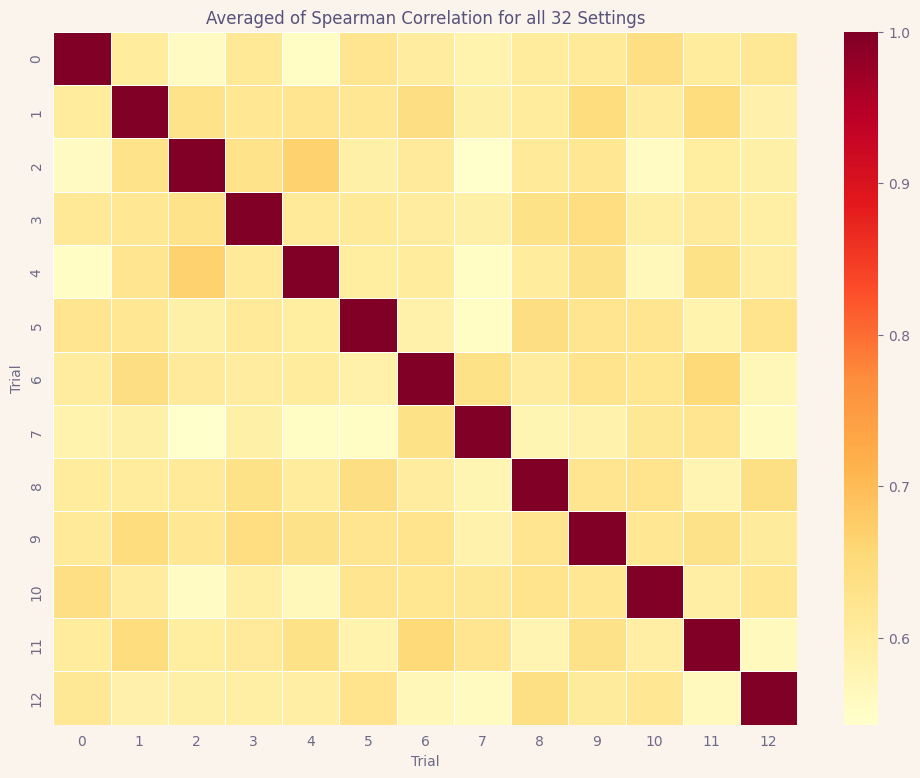

P-values:
Trial 1 vs Trial 3: 2.5788060945001467e-211
Trial 1 vs Trial 5: 1.3924501113855897e-300
Trial 1 vs Trial 6: 3.7359320282935955e-269
Trial 1 vs Trial 7: 4.791141364887941e-289
Trial 1 vs Trial 8: 3.854020238789676e-150
Trial 1 vs Trial 9: 7.183894327720845e-198
Trial 1 vs Trial 10: 1.9758511628372726e-220
Trial 1 vs Trial 12: 1.0353600082589672e-91
Trial 2 vs Trial 5: 3.150850770771056e-282
Trial 2 vs Trial 6: 5.290069573565748e-306
Trial 2 vs Trial 8: 1.4283558322640513e-254
Trial 2 vs Trial 9: 1.1511169563839686e-159
Trial 2 vs Trial 12: 3.995519951256068e-254
Trial 2 vs Trial 13: 1.9205497248813953e-262
Trial 3 vs Trial 1: 2.5788060945001467e-211
Trial 3 vs Trial 6: 4.069257871332279e-224
Trial 3 vs Trial 8: 2.053628923884639e-30
Trial 3 vs Trial 10: 2.4523585533484054e-201
Trial 3 vs Trial 12: 4.740900928085904e-228
Trial 4 vs Trial 5: 1.4343068755469213e-286
Trial 4 vs Trial 8: 1.025852980094353e-154
Trial 4 vs Trial 9: 9.966644487433594e-233
Trial 4 vs Trial 11: 7.344742

In [40]:
spearman_trials(df_list=df_list)

### Settings for 0-1 active rule

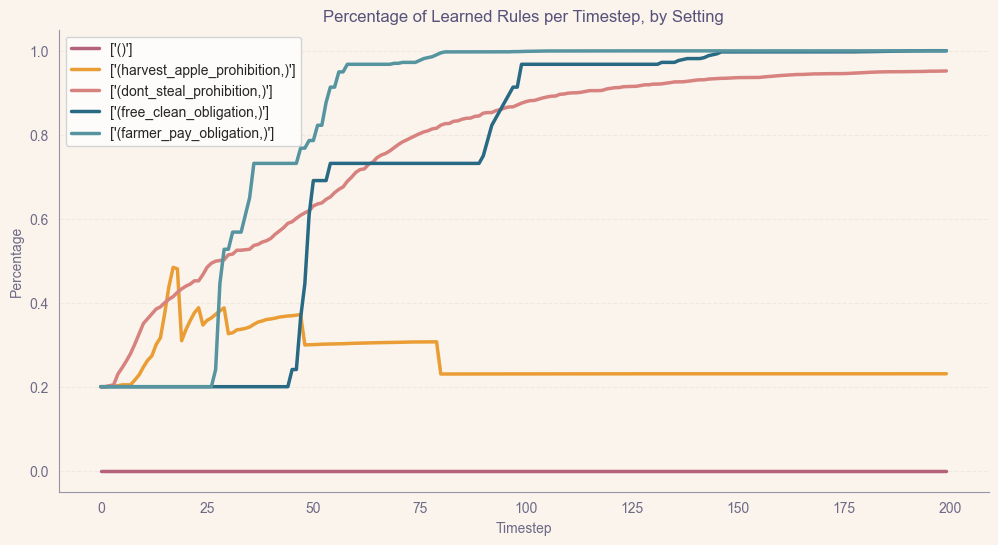

In [41]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_1, setting_str=setting_str
)

### Settings for 2 active rules

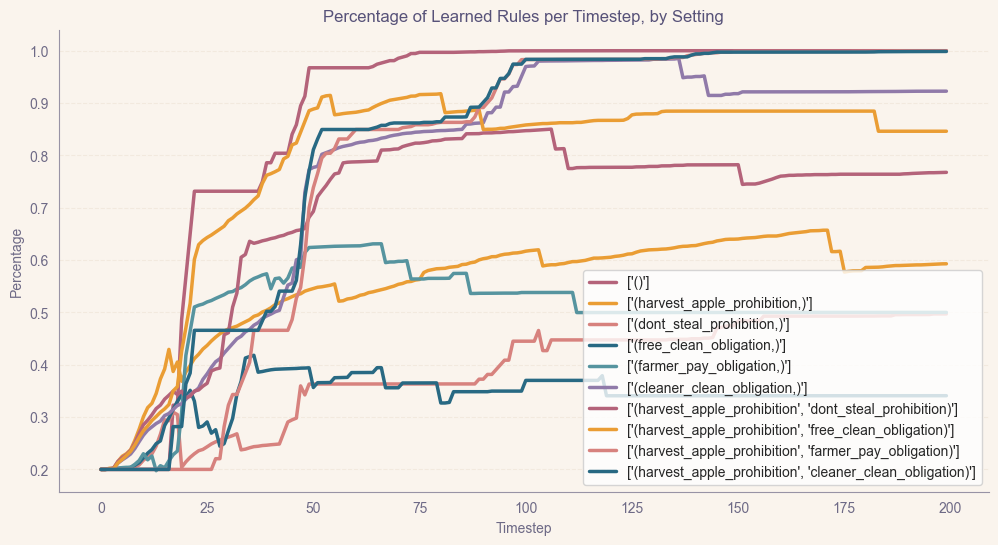

In [42]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_2, setting_str=setting_str
)

### Settings for 3 active rules

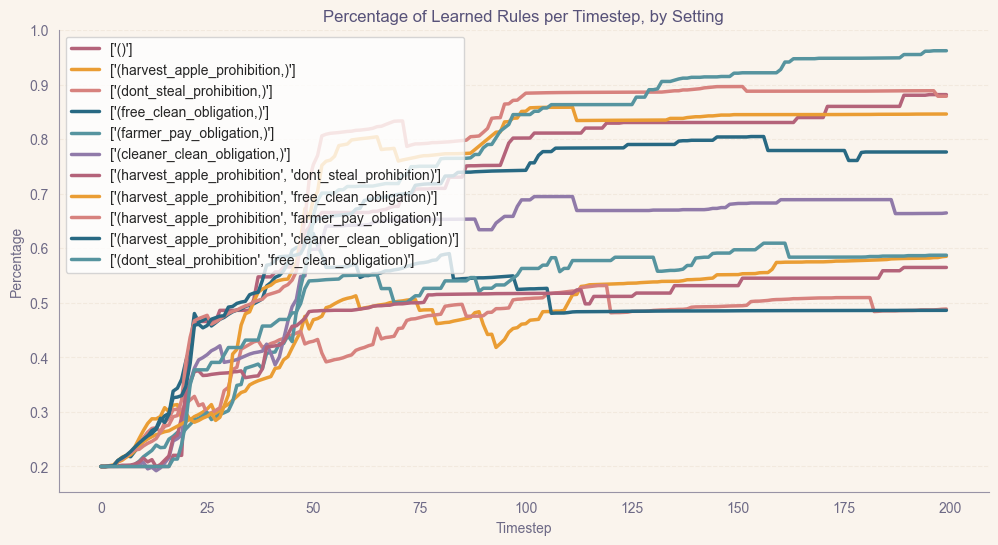

In [43]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_3, setting_str=setting_str
)

### Settings for 4-5 active rules

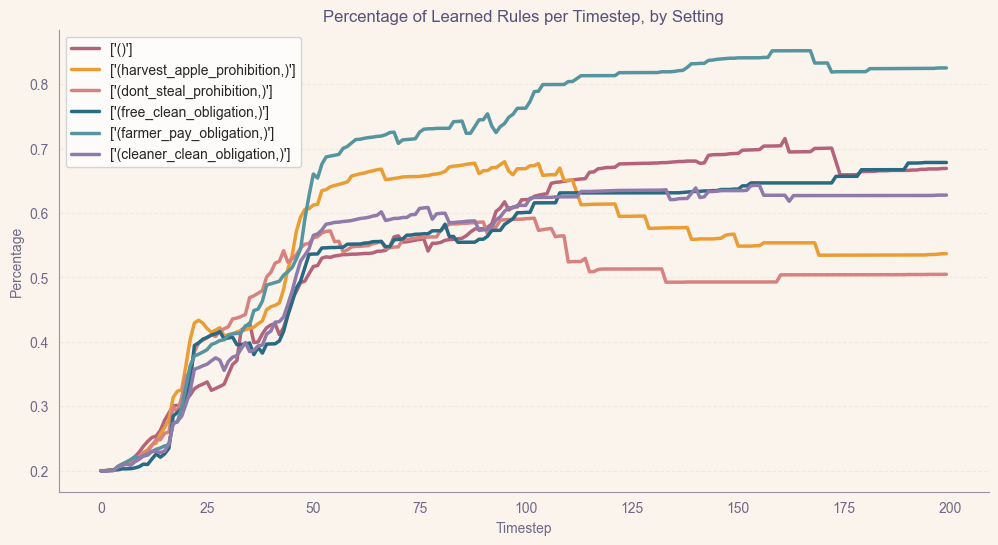

In [44]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_4, setting_str=setting_str
)

## B.1 Ratio of Learned Rules — Per Rule, Rule Combinations

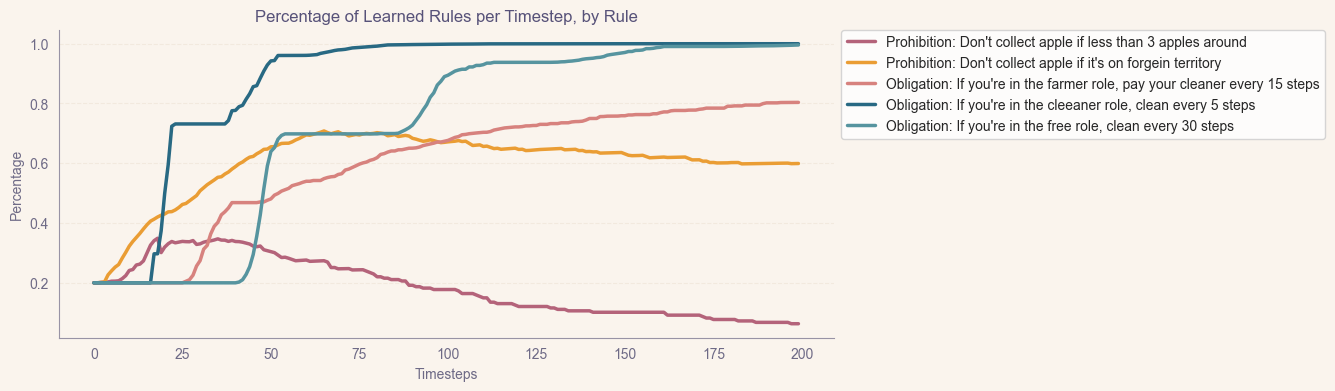

In [45]:
plot_single_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, setting_str=setting_str
)

## C.1 Percentage of Learned Rules at Certain Timestep, Rule Combinations

### — Grouped by Rule

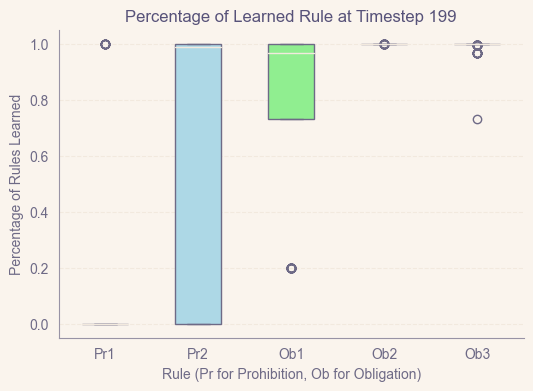

In [46]:
# data must be formatted s.t. data[timestep] is all data for one timestep
plot_rule_after_timestep_x(all_values=continuous_rules, timestep=199)

### -- Grouped by Setting

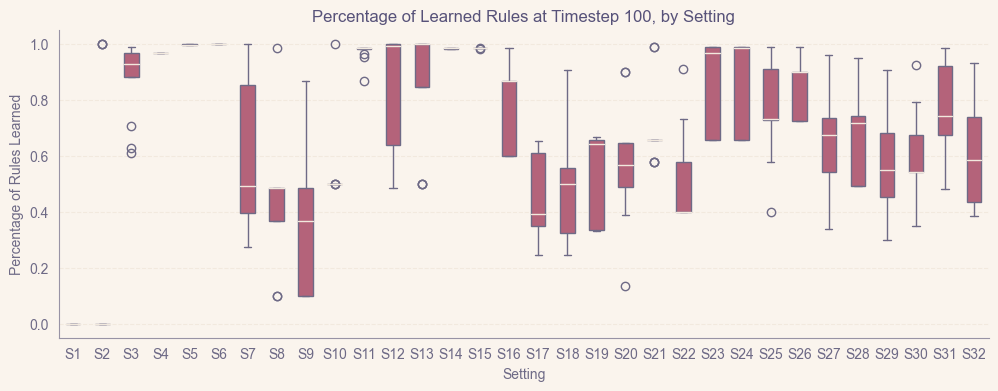

In [47]:
plot_percentage_per_timestep(continuous_timesteps=continuous_timesteps, timestep=100)

## D.1 Timesteps where Certain Percentage of Rules has been learned

### -- Grouped by Rule

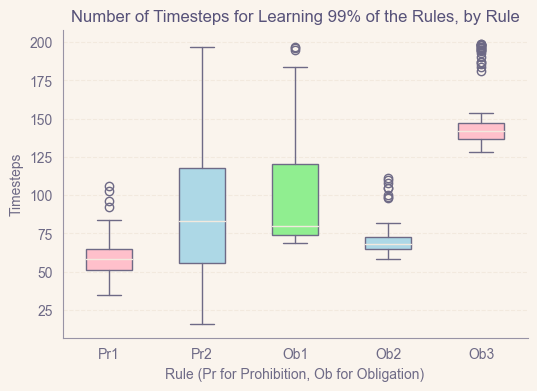

In [48]:
plot_rule_timestep_at_percentage(all_values=continuous_rules, percentage=0.99)

### -- Grouped by Setting

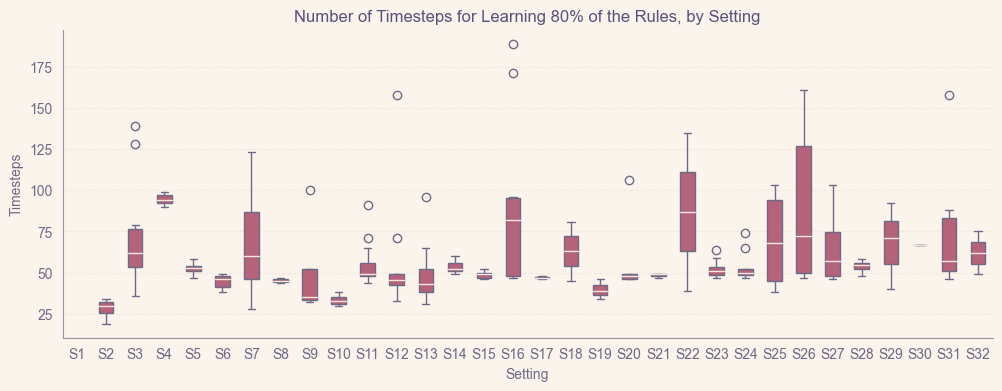

In [49]:
plot_timestep_per_percentage(continuous_timesteps=continuous_timesteps, percentage=0.8)

## E.1 Plot F1 Scores for all Combinations

### -- Across All Settings

In [50]:
precisions, recalls, f1s = get_f1_across_settings_per_specific_ts_and_percentage(percentages=target_percentages, 
                                                      timesteps=target_timesteps, 
                                                      df_list=df_list, 
                                                      settings_str=setting_str)

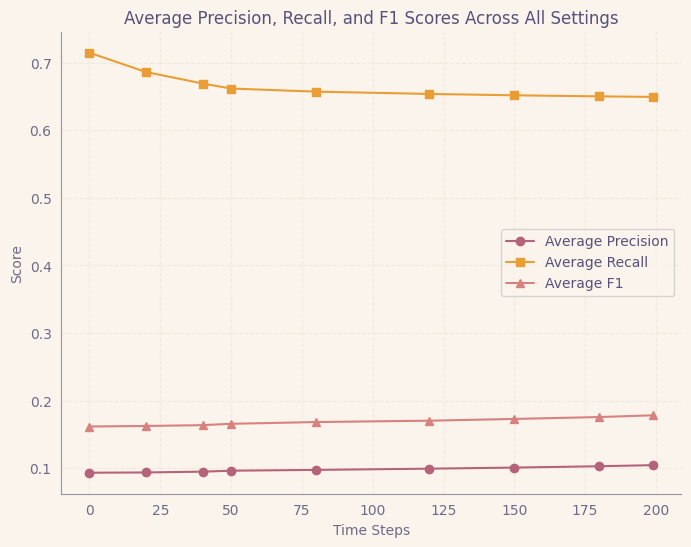

In [51]:
plot_avg_pre_rec_f1(precision_values=precisions, recall_values=recalls, f1_values=f1s, timesteps=target_timesteps)

### -- Per Setting Across Timesteps and Posteriors

In [52]:
precisions, recalls, f1s = get_f1_across_timesteps_and_percentages(percentages=target_percentages, 
                                        timesteps=target_timesteps, 
                                        df_list=df_list, 
                                        settings_str=setting_str)

Across all settings, timesteps, and percentages:	Pre: 0.116, Rec: 0.516, F1: 0.19


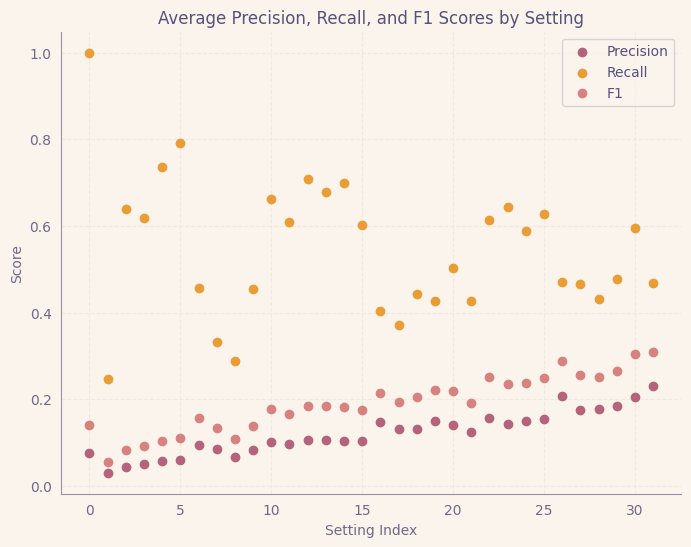

In [53]:
plot_avg_pre_rec_f1_per_setting(precision_values=precisions, recall_values=recalls, f1_values=f1s)

# A.2 Learned Rules — Role Combinations

In [54]:
num_settings = 8
setting_str = 'test' # 'rules' or 'test'
df_list = test_dfs

results = extract_timesteps(input_dfs=df_list, num_settings=num_settings, setting_str=setting_str,
                target_percentages=target_percentages, target_timesteps=target_timesteps)

ALL_RULES = PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER + OBLIGATION_FREE
single_rule_results = extract_rules(input_dfs=df_list, num_settings=num_settings, rules=ALL_RULES, setting_str=setting_str)

percentages_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
timesteps_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_timesteps = [[[] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_rules = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(ALL_RULES))]

for result in results:
    setting = result['setting']
    trial = result['trial']
    timesteps = result['discrete_timesteps']
    percentages = result['discrete_percentages']
    all_values = result['all_values']
    continuous_timesteps[setting][trial] = all_values
    
    for i in range(num_timesteps):
        timestep = i
        timesteps_all[setting][trial][timestep] = timesteps[i]
        percentages_all[setting][trial][timestep] = percentages[i]

for result in single_rule_results:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules[rule_idx][setting][trial] = all_values

## Spearman Correlation

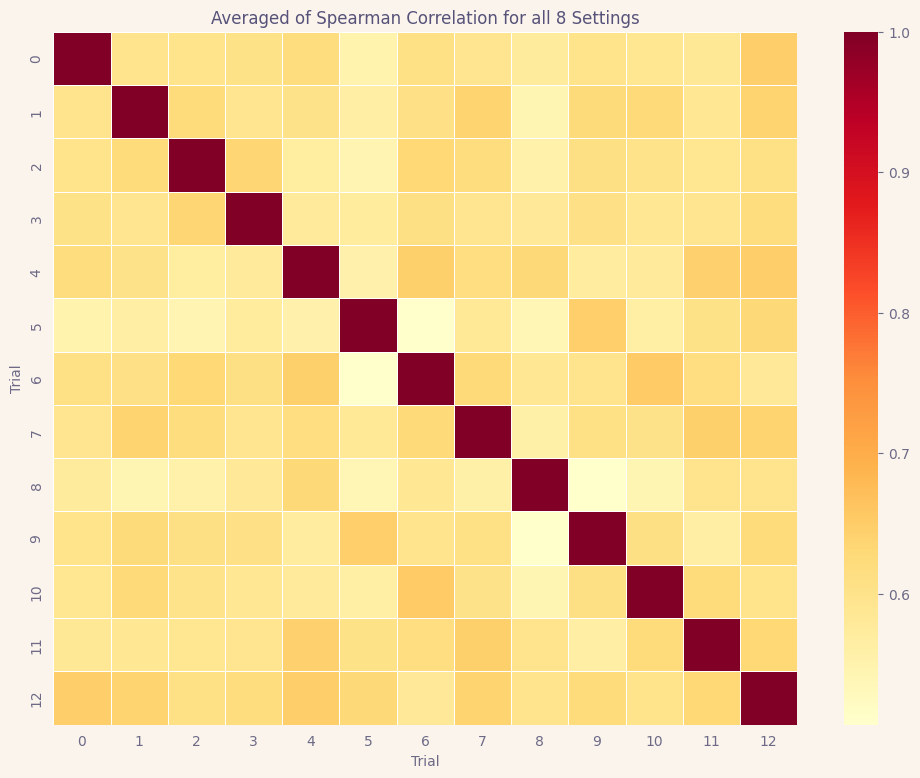

P-values:
Trial 2 vs Trial 5: 5.40226699895242e-181
Trial 2 vs Trial 9: 4.746499277574388e-280
Trial 2 vs Trial 12: 1.2540504055203099e-305
Trial 3 vs Trial 5: 9.555197516038173e-250
Trial 3 vs Trial 12: 1.414381465705915e-263
Trial 4 vs Trial 5: 1.2168713916703324e-284
Trial 4 vs Trial 7: 7.140890615819485e-297
Trial 4 vs Trial 11: 7.45202607571927e-171
Trial 4 vs Trial 12: 1.2449531391703553e-298
Trial 5 vs Trial 2: 5.40226699895242e-181
Trial 5 vs Trial 3: 9.555197516038173e-250
Trial 5 vs Trial 4: 1.2168713916703324e-284
Trial 5 vs Trial 10: 8.743702959897832e-177
Trial 5 vs Trial 11: 3.0211636876929927e-241
Trial 6 vs Trial 7: 2.958242893066688e-234
Trial 6 vs Trial 9: 6.892504313860467e-206
Trial 7 vs Trial 4: 7.140890615819485e-297
Trial 7 vs Trial 6: 2.958242893066688e-234
Trial 7 vs Trial 9: 5.8669868617339215e-195
Trial 8 vs Trial 9: 4.973113913303079e-280
Trial 9 vs Trial 2: 4.746499277574388e-280
Trial 9 vs Trial 6: 6.892504313861643e-206
Trial 9 vs Trial 7: 5.8669868617339

In [55]:
spearman_trials(df_list=df_list)

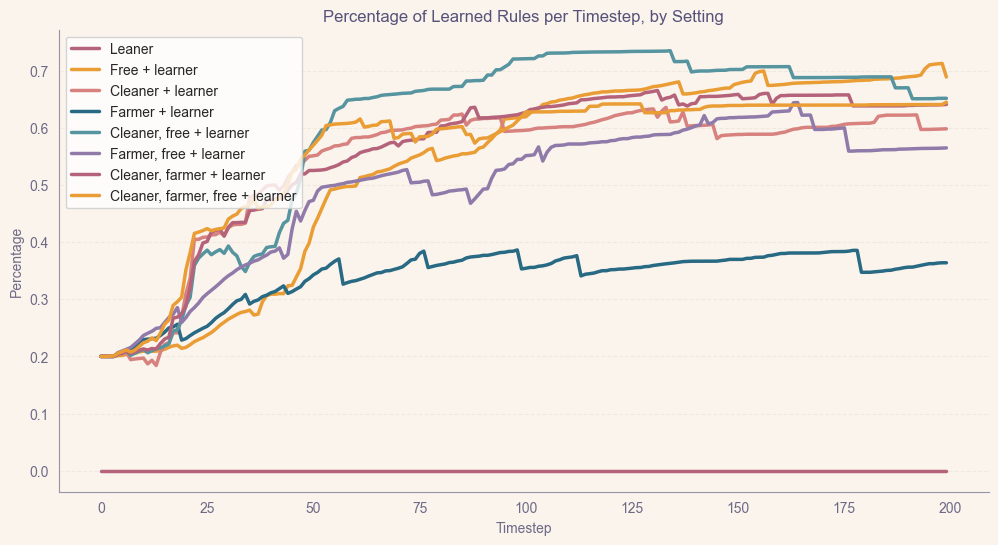

In [56]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps, setting_str=setting_str
)

## B.2 Ratio of Learned Rules — Per Rule, Role Combinations

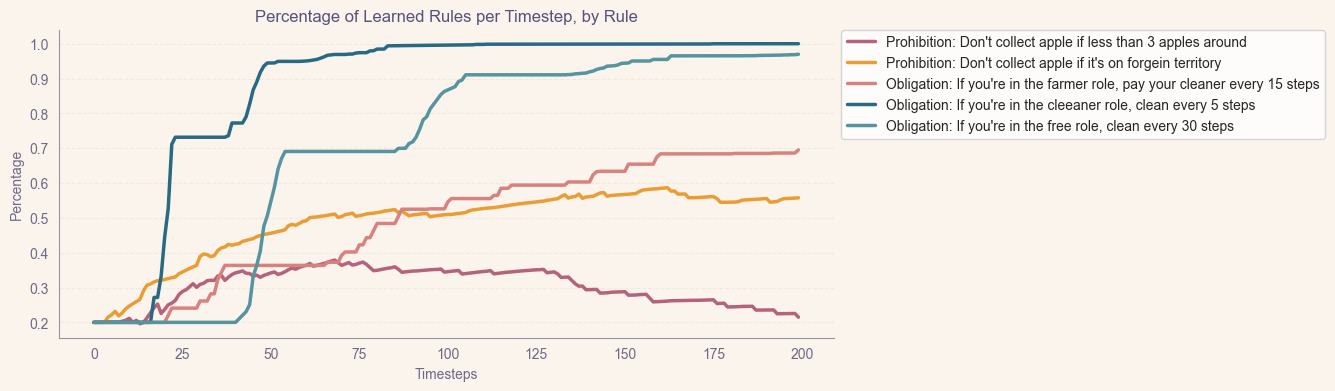

In [57]:
plot_single_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, setting_str=setting_str
)

## C.2 Percentage of Learned Rules at Certain Timestep, Role Combinations

### -- Grouped by Rule

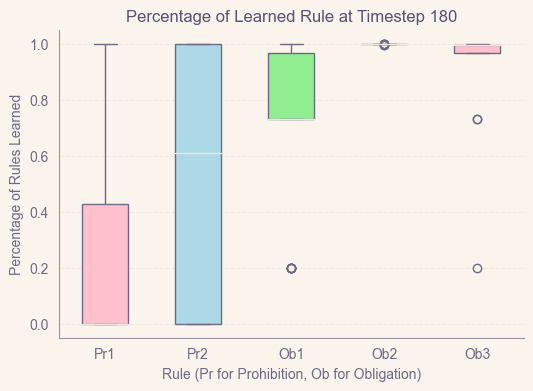

In [58]:
# data must be formatted s.t. data[timestep] is all data for one timestep
plot_rule_after_timestep_x(all_values=continuous_rules, timestep=180)

## - Grouped by Setting

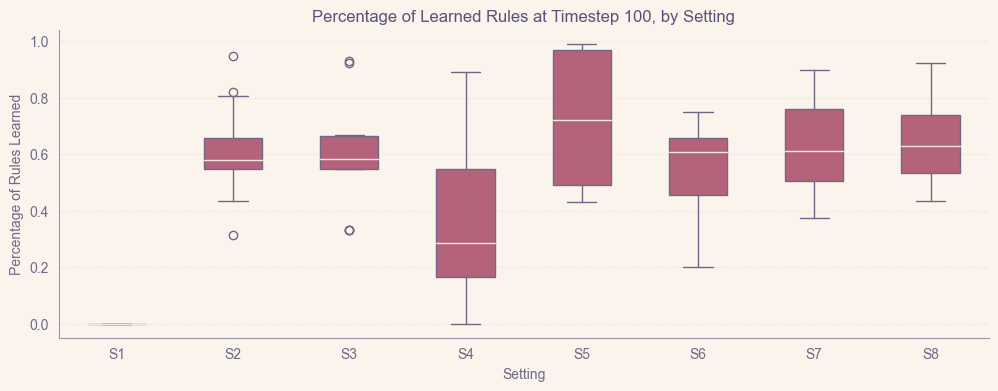

In [59]:
plot_percentage_per_timestep(continuous_timesteps=continuous_timesteps, timestep=100)

## D.2 Timesteps where Certain Percentage of Rules has been learned (TODO)

### -- Grouped by Rule

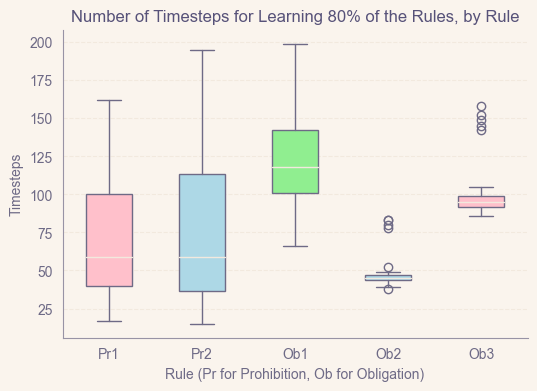

In [60]:
plot_rule_timestep_at_percentage(all_values=continuous_rules, percentage=0.8)

### -- Grouped by Setting

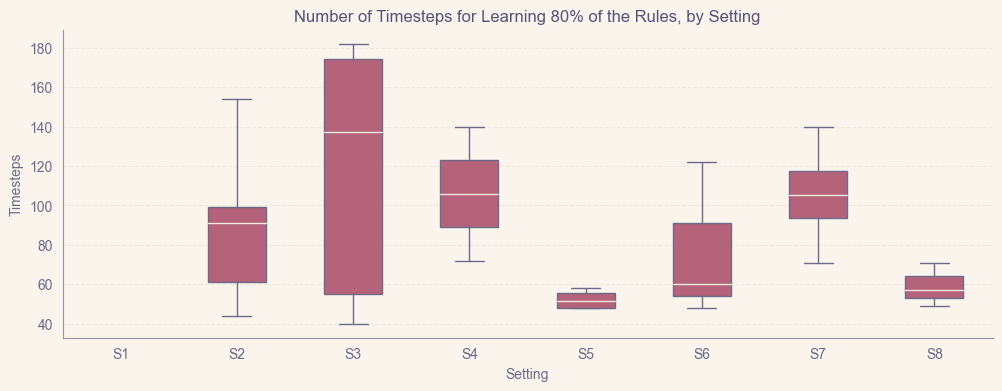

In [61]:
plot_timestep_per_percentage(continuous_timesteps=continuous_timesteps, percentage=0.8)

## E.2 F1 Scores for all Combinations

### -- Per Setting Across Settings (Grouped by Timesteps and Posteriors)

In [62]:
precisions, recalls, f1s = get_f1_across_settings_per_specific_ts_and_percentage(percentages=target_percentages, 
                                                      timesteps=target_timesteps, 
                                                      df_list=df_list, 
                                                      settings_str=setting_str)

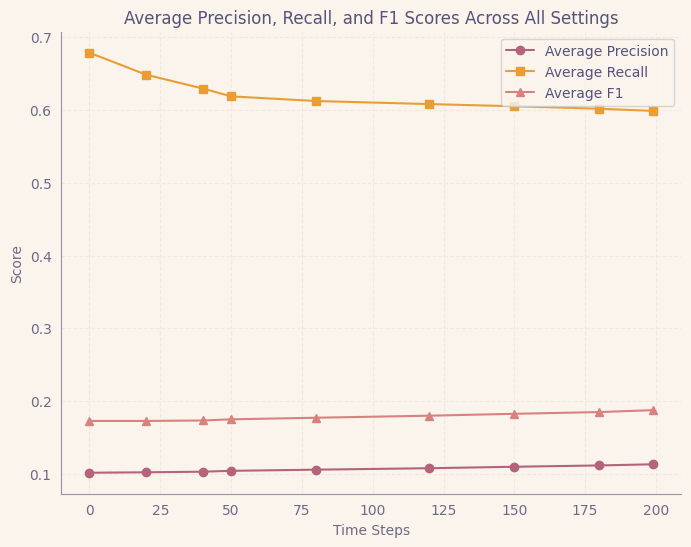

In [63]:
plot_avg_pre_rec_f1(precision_values=precisions, recall_values=recalls, f1_values=f1s, timesteps=target_timesteps)

In [64]:
# plot_pre_rec_f1(precision_values=precisions, recall_values=recalls, f1_values=f1s, timesteps=target_timesteps)

### -- Per Setting Across Timesteps and Posteriors (Grouped by Setting)

In [69]:
precisions, recalls, f1s = get_f1_across_timesteps_and_percentages(percentages=target_percentages, 
                                        timesteps=target_timesteps, 
                                        df_list=df_list, 
                                        settings_str=setting_str)

Across all settings, timesteps, and percentages:	Pre: 0.129, Rec: 0.452, F1: 0.201


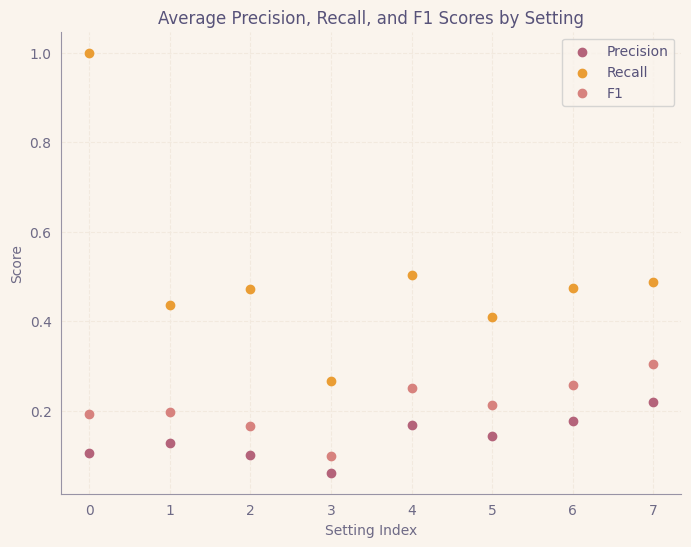

In [70]:
plot_avg_pre_rec_f1_per_setting(precision_values=precisions, recall_values=recalls, f1_values=f1s)

# Cross-Overs

Data Of Interest:
- A. Reward Per Learned Rules
- B. Reward per Number of Learned Rules

## 1. Rule Combinations

## A.1 Reward Per Learned Rules — Rule Combinations

In [49]:
# TODO

## B.1 Reward per Number of Learned Rules — Rule Combinations

In [50]:
# TODO

## 2. Role Combinations

## A.2 Reward Per Learned Rules — Role Combinations

In [51]:
# TODO

## B.2 Reward per Number of Learned Rules — Role Combinations

In [52]:
# TODO